In [1]:
import pandas as pd
# https://github.com/SohierDane/BigQuery_Helper
"""
Helper class to simplify common read-only BigQuery tasks.
"""


import pandas as pd
import time

from google.cloud import bigquery


class BigQueryHelper(object):
    """
    Helper class to simplify common BigQuery tasks like executing queries,
    showing table schemas, etc without worrying about table or dataset pointers.

    See the BigQuery docs for details of the steps this class lets you skip:
    https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html
    """

    def __init__(self, active_project, dataset_name, max_wait_seconds=180):
        self.project_name = active_project
        self.dataset_name = dataset_name
        self.max_wait_seconds = max_wait_seconds
        self.client = bigquery.Client()
        self.__dataset_ref = self.client.dataset(self.dataset_name, project=self.project_name)
        self.dataset = None
        self.tables = dict()  # {table name (str): table object}
        self.__table_refs = dict()  # {table name (str): table reference}
        self.total_gb_used_net_cache = 0
        self.BYTES_PER_GB = 2**30

    def __fetch_dataset(self):
        """
        Lazy loading of dataset. For example,
        if the user only calls `self.query_to_pandas` then the
        dataset never has to be fetched.
        """
        if self.dataset is None:
            self.dataset = self.client.get_dataset(self.__dataset_ref)

    def __fetch_table(self, table_name):
        """
        Lazy loading of table
        """
        self.__fetch_dataset()
        if table_name not in self.__table_refs:
            self.__table_refs[table_name] = self.dataset.table(table_name)
        if table_name not in self.tables:
            self.tables[table_name] = self.client.get_table(self.__table_refs[table_name])

    def __handle_record_field(self, row, schema_details, top_level_name=''):
        """
        Unpack a single row, including any nested fields.
        """
        name = row['name']
        if top_level_name != '':
            name = top_level_name + '.' + name
        schema_details.append([{
            'name': name,
            'type': row['type'],
            'mode': row['mode'],
            'fields': pd.np.nan,
            'description': row['description']
                               }])
        # float check is to dodge row['fields'] == np.nan
        if type(row.get('fields', 0.0)) == float:
            return None
        for entry in row['fields']:
            self.__handle_record_field(entry, schema_details, name)

    def __unpack_all_schema_fields(self, schema):
        """
        Unrolls nested schemas. Returns dataframe with one row per field,
        and the field names in the format accepted by the API.
        Results will look similar to the website schema, such as:
            https://bigquery.cloud.google.com/table/bigquery-public-data:github_repos.commits?pli=1

        Args:
            schema: DataFrame derived from api repr of raw table.schema
        Returns:
            Dataframe of the unrolled schema.
        """
        schema_details = []
        schema.apply(lambda row:
            self.__handle_record_field(row, schema_details), axis=1)
        result = pd.concat([pd.DataFrame.from_dict(x) for x in schema_details])
        result.reset_index(drop=True, inplace=True)
        del result['fields']
        return result

    def table_schema(self, table_name):
        """
        Get the schema for a specific table from a dataset.
        Unrolls nested field names into the format that can be copied
        directly into queries. For example, for the `github.commits` table,
        the this will return `committer.name`.

        This is a very different return signature than BigQuery's table.schema.
        """
        self.__fetch_table(table_name)
        raw_schema = self.tables[table_name].schema
        schema = pd.DataFrame.from_dict([x.to_api_repr() for x in raw_schema])
        # the api_repr only has the fields column for tables with nested data
        if 'fields' in schema.columns:
            schema = self.__unpack_all_schema_fields(schema)
        # Set the column order
        schema = schema[['name', 'type', 'mode', 'description']]
        return schema

    def list_tables(self):
        """
        List the names of the tables in a dataset
        """
        self.__fetch_dataset()
        return([x.table_id for x in self.client.list_tables(self.dataset)])

    def estimate_query_size(self, query):
        """
        Estimate gigabytes scanned by query.
        Does not consider if there is a cached query table.
        See https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
        """
        my_job_config = bigquery.job.QueryJobConfig()
        my_job_config.dry_run = True
        my_job = self.client.query(query, job_config=my_job_config)
        return my_job.total_bytes_processed / self.BYTES_PER_GB

    def query_to_pandas(self, query):
        """
        Execute a SQL query & return a pandas dataframe
        """
        my_job = self.client.query(query)
        start_time = time.time()
        while not my_job.done():
            if (time.time() - start_time) > self.max_wait_seconds:
                print("Max wait time elapsed, query cancelled.")
                self.client.cancel_job(my_job.job_id)
                return None
            time.sleep(0.1)
        # Queries that hit errors will return an exception type.
        # Those exceptions don't get raised until we call my_job.to_dataframe()
        # In that case, my_job.total_bytes_billed can be called but is None
        if my_job.total_bytes_billed:
            self.total_gb_used_net_cache += my_job.total_bytes_billed / self.BYTES_PER_GB
        return my_job.to_dataframe()

    def query_to_pandas_safe(self, query, max_gb_scanned=1):
        """
        Execute a query, but only if the query would scan less than `max_gb_scanned` of data.
        """
        query_size = self.estimate_query_size(query)
        if query_size <= max_gb_scanned:
            return self.query_to_pandas(query)
        msg = "Query cancelled; estimated size of {0} exceeds limit of {1} GB"
        print(msg.format(query_size, max_gb_scanned))

    def head(self, table_name, num_rows=5, start_index=None, selected_columns=None):
        """
        Get the first n rows of a table as a DataFrame.
        Does not perform a full table scan; should use a trivial amount of data as long as n is small.
        """
        self.__fetch_table(table_name)
        active_table = self.tables[table_name]
        schema_subset = None
        if selected_columns:
            schema_subset = [col for col in active_table.schema if col.name in selected_columns]
        results = self.client.list_rows(active_table, selected_fields=schema_subset,
            max_results=num_rows, start_index=start_index)
        results = [x for x in results]
        return pd.DataFrame(
            data=[list(x.values()) for x in results], columns=list(results[0].keys()))

In [2]:
bq_assistant = BigQueryHelper("bigquery-public-data", "github_repos", 99999999999999)

In [9]:
QUERY = """
        SELECT commits.message, commits.author, commits.repo_name[0] as repo, languages.language
        FROM `bigquery-public-data.github_repos.commits` AS commits
        LEFT JOIN `bigquery-public-data.github_repos.languages` AS languages
        ON commits.repo_name[0] = languages.repo_name
        WHERE commits.repo_name[0] IN 
            (SELECT DISTINCT repo_name[0] 
            FROM `bigquery-public-data.github_repos.commits`
            WHERE ARRAY_LENGTH(repo_name)=1 and REGEXP_CONTAINS(message, '[a-zA-Z0-9]+([(].*[)]){0,1}!{0,1}:[ ]*.*$')
            LIMIT 10000)
        """
print(bq_assistant.estimate_query_size(QUERY))

138.45546568464488


In [10]:
%%time
df = bq_assistant.query_to_pandas_safe(QUERY, 140)

CPU times: user 19min 6s, sys: 49 s, total: 19min 55s
Wall time: 41min 18s


In [11]:
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))

Size of dataframe: 2439380529 Bytes


In [12]:
df.head()

,message,author,repo,language
0,Merge pull request #26 from plumgrid/fawadk-de...,"{'name': 'Fawad Khaliq', 'email': '4856592176e...",plumgrid/libnetwork-plugin,"[{'name': 'Go', 'bytes': 46980}, {'name': 'Mak..."
1,Merge pull request #48 from plumgrid/qasims-de...,"{'name': 'Fawad Khaliq', 'email': '4856592176e...",plumgrid/libnetwork-plugin,"[{'name': 'Go', 'bytes': 46980}, {'name': 'Mak..."
2,Update README.md\n\nAdding quick start instruc...,"{'name': 'Muhammad Sagheer', 'email': '6e79461...",plumgrid/libnetwork-plugin,"[{'name': 'Go', 'bytes': 46980}, {'name': 'Mak..."
3,Changed grid size for landscape orientation,"{'name': 'Elman', 'email': '59c728d38dfde4d631...",elman22/pocket-amc-reader,"[{'name': 'Java', 'bytes': 368925}]"
4,Added Polish translation files,"{'name': 'Elman', 'email': '59c728d38dfde4d631...",elman22/pocket-amc-reader,"[{'name': 'Java', 'bytes': 368925}]"


In [13]:
df.shape

(4125158, 4)

In [14]:
df.to_csv('Repo_Messages_Huge_Set.csv, index=false')

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

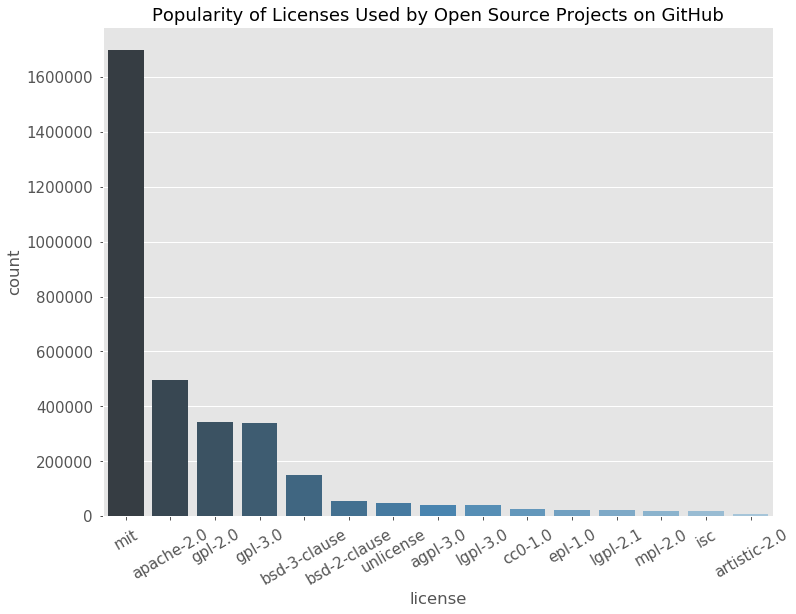

In [24]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

f, g = plt.subplots(figsize=(12, 9))
g = sns.barplot(x="license", y="count", data=df, palette="Blues_d")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.title("Popularity of Licenses Used by Open Source Projects on GitHub")
plt.show(g)

Beautiful! We already knew that MIT was the most popular license by far, but here we see it in plain contrast to the next most common licenses, Apache 2.0 and GPL 2.0 and 3.0. For the record, this kernel is Apache 2.0-licensed. :)

## Conclusion

I hope you've enjoyed this kernel and learned at least something new. I know I felt confident about exploring this massive 3TB dataset knowing the functions available to me in `bq_helper` would prevent me from accidentally exceeding my quota. Here are some additional resources for working with BigQuery datasets in Kaggle Kernels:

* New to SQL? Learn this practical language by signing up for our [5-day SQL Scavenger Hunt](https://www.kaggle.com/sql-scavenger-hunt) which starts February 15th
* [A collection of all BigQuery resources on Kaggle](https://www.kaggle.com/product-feedback/48573)
* [Learn more about the BigQuery Python client library here](https://www.kaggle.com/sohier/beyond-queries-exploring-the-bigquery-api)
* Explore [all BigQuery datasets available on Kaggle](https://www.kaggle.com/datasets?filetype=bigQuery)--each has its own "starter kernel" for you to fork